In [3]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import pdb
from collections import defaultdict
### These imports give fit_transform method for free ###
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import pdb
from collections import defaultdict
import pickle

In [3]:
# import the scikit-learn compatible transformer pipeline ##
#from simformer import SimFormer

In [49]:
datapath = r'../Data/training_df.csv'


In [50]:
###### train data set for the model #####
df = pd.read_csv(datapath)
print(df.shape)
df['isCalifornia'] = False
df['isTexas'] = False
for i in range(len(df)):
    if df['state'].iloc[i] == 'California':
        df['isCalifornia'].iloc[i] = True    
    if df['state'].iloc[i] == 'Texas':
        df['isTexas'].iloc[i] = True
df.head()



FileNotFoundError: [Errno 2] No such file or directory: '../Data/training_df.csv'

In [31]:
from featurewiz import FeatureWiz

Imported 0.2.04 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [32]:
### Once the SimFormer pipeline is built, it can work with Featurewiz ##
#smp = SimFormer(with_model=False, date_to_string=False)
FW = FeatureWiz()

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        


In [33]:
target = 'will_churn'
modeltype = 'Classification'

In [34]:
if isinstance(target, str):
    cols = [x for x in list(df) if x not in [target]]
else:
    cols = [x for x in list(df) if x not in target]
X = df[cols]
X = X.drop(columns=['customer_id','date','start_balance','state'])
y = df[target]
X.dtypes

amount              float64
age                 float64
account_maturity    float64
current_balance     float64
FEDFUNDS            float64
GDP_PCH             float64
Inflation           float64
previous_balance    float64
big_withdraw           bool
neg_growth            int64
isCalifornia           bool
isTexas                bool
dtype: object

In [8]:
###  find the y values that have low samples ####
if modeltype != 'Regression':
    low_counts = y.value_counts()[(y.value_counts()<=1).values].index
    print(len(low_counts))
    ## You need to remove those rows that have just one sample ##
    X = X[~(y.isin(low_counts))]
    y = y[~(y.isin(low_counts))]
X.shape, y.shape

0


((2126348, 13), (2126348,))

In [35]:
from sklearn.model_selection import train_test_split
if modeltype == 'Regression':
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=999)
else:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y, random_state=999)
print(X_train.shape, X_test.shape)

(1913713, 12) (212635, 12)


In [12]:
### This returns a transformer + feature selection pipeline once you fit it ###
#mlp = smp.fit(X_train, y_train)
#FW.fit(X_train, y_train)

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
#import optuna
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
pipe = Pipeline([('fw', FeatureWiz()),('classifier', RandomForestClassifier())])
param_grid = {'classifier__bootstrap': [True],
                'classifier__n_estimators':[100],
                'classifier__max_depth': [None],
                'classifier__max_features': ['log2', 'sqrt'],
                'classifier__min_samples_leaf': [1, 2, 4],
                'classifier__min_samples_split': [2, 5, 10]}
search = RandomizedSearchCV(estimator=pipe,
                            param_distributions=param_grid,
                            scoring='accuracy',
                            n_iter=3,
                            n_jobs=-1,
                            random_state=99,
                            cv=3,
                            error_score=1)

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        


In [1]:
import optuna

In [13]:
from sklearn.metrics import precision_recall_curve, f1_score, balanced_accuracy_score, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import optuna

def objective(trial):
    max_features = trial.suggest_categorical('max_features', ['sqrt','log2'])
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    model = RandomForestClassifier(
            max_features=max_features,
            n_estimators=n_estimators,
            max_depth = max_depth,
            min_samples_leaf = min_samples_leaf,
            min_samples_split= min_samples_split
        )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    return recall
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f'    {key}: {value}')
model_opt = RandomForestClassifier(
    n_estimators=trial.params['n_estimators'],
    max_depth=trial.params['max_depth'],
    min_samples_leaf=trial.params['min_samples_leaf'],
    min_samples_split=trial.params['min_samles_split'],
    max_features=trial.params['max_features']
)
model_opt.fit(X_train, y_train)
y_pred = model_opt.predict(X_test)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bas = balanced_accuracy_score(y_test, y_pred)
print(
    f'Performance Metrics:\nrecall score: {recall:.3f}\nf1 score: {f1:.3f}\nbalanced accuracy score: {bas:.3f}')

[I 2023-03-01 14:04:17,411] A new study created in memory with name: no-name-4f8f44e6-b7f5-437e-b7f7-97224e3e95b8
[I 2023-03-01 14:10:15,824] Trial 0 finished with value: 0.0 and parameters: {'max_features': 'sqrt', 'n_estimators': 389, 'max_depth': 2, 'min_samples_leaf': 33, 'min_samples_split': 26}. Best is trial 0 with value: 0.0.
[I 2023-03-01 14:13:34,291] Trial 1 finished with value: 0.0 and parameters: {'max_features': 'sqrt', 'n_estimators': 118, 'max_depth': 4, 'min_samples_leaf': 22, 'min_samples_split': 3}. Best is trial 0 with value: 0.0.
[I 2023-03-01 14:23:37,142] Trial 2 finished with value: 0.0 and parameters: {'max_features': 'log2', 'n_estimators': 251, 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 15}. Best is trial 0 with value: 0.0.
[I 2023-03-01 14:29:55,730] Trial 3 finished with value: 0.0 and parameters: {'max_features': 'log2', 'n_estimators': 408, 'max_depth': 2, 'min_samples_leaf': 21, 'min_samples_split': 36}. Best is trial 0 with value: 0.0.


KeyboardInterrupt: 

In [26]:
model = RandomForestClassifier(
            max_features='sqrt',
            n_estimators=389,
            max_depth = 8,
            min_samples_leaf = 33,
            min_samples_split= 26
        )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
recall = recall_score(y_test, y_pred)
 


In [17]:
print(balanced_accuracy_score(y_test, y_pred))

0.5


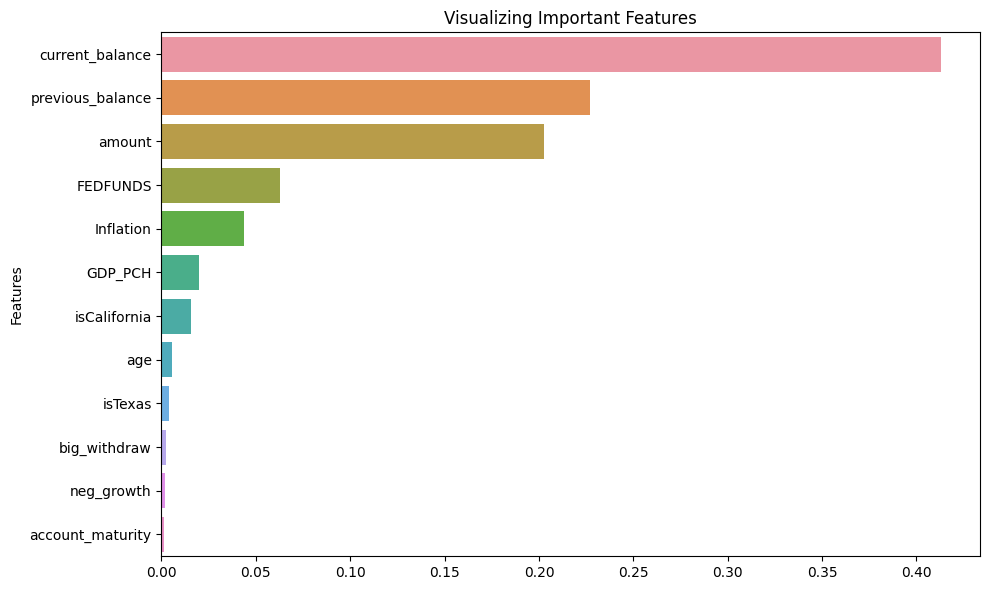

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
feature_imp = pd.Series(model.feature_importances_, index = model.feature_names_in_).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graphplt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()
plt.show()

In [14]:
X.isna().sum()

amount                         0
age                            0
account_maturity               0
current_balance                0
FEDFUNDS                       0
GDP_PCH                        0
Inflation                      0
days_since_last_transaction    0
dtype: int64

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
 

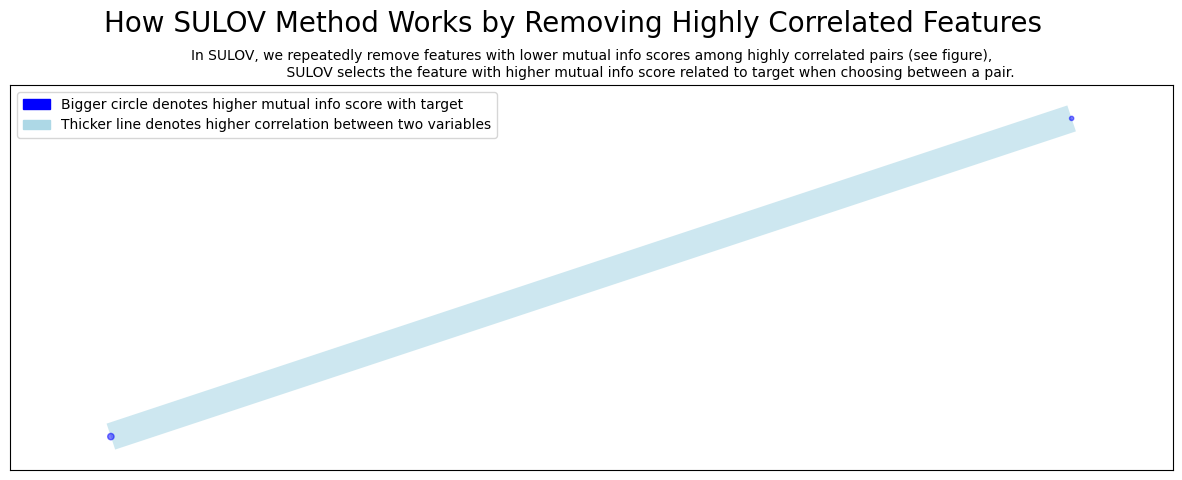

Time taken for SULOV method = 37 seconds
    Adding 3 categorical variables to reduced numeric variables  of 8
Final list of selected 11 vars after SULOV = ['FEDFUNDS', 'GDP_PCH', 'Inflation', 'account_maturity', 'age', 'amount', 'neg_growth', 'current_balance', 'big_withdraw', 'isCalifornia', 'isTexas']
Converting all features to numeric before sending to XGBoost...
    there were no mixed data types or object columns that errored. Data is all numeric...
Shape of train data after adding missing values flags = (1913713, 12)
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 11 
    Taking top 3 features per iteration...
    XGBoost version using 1.7.1 as tree method: hist
Number of booster rounds

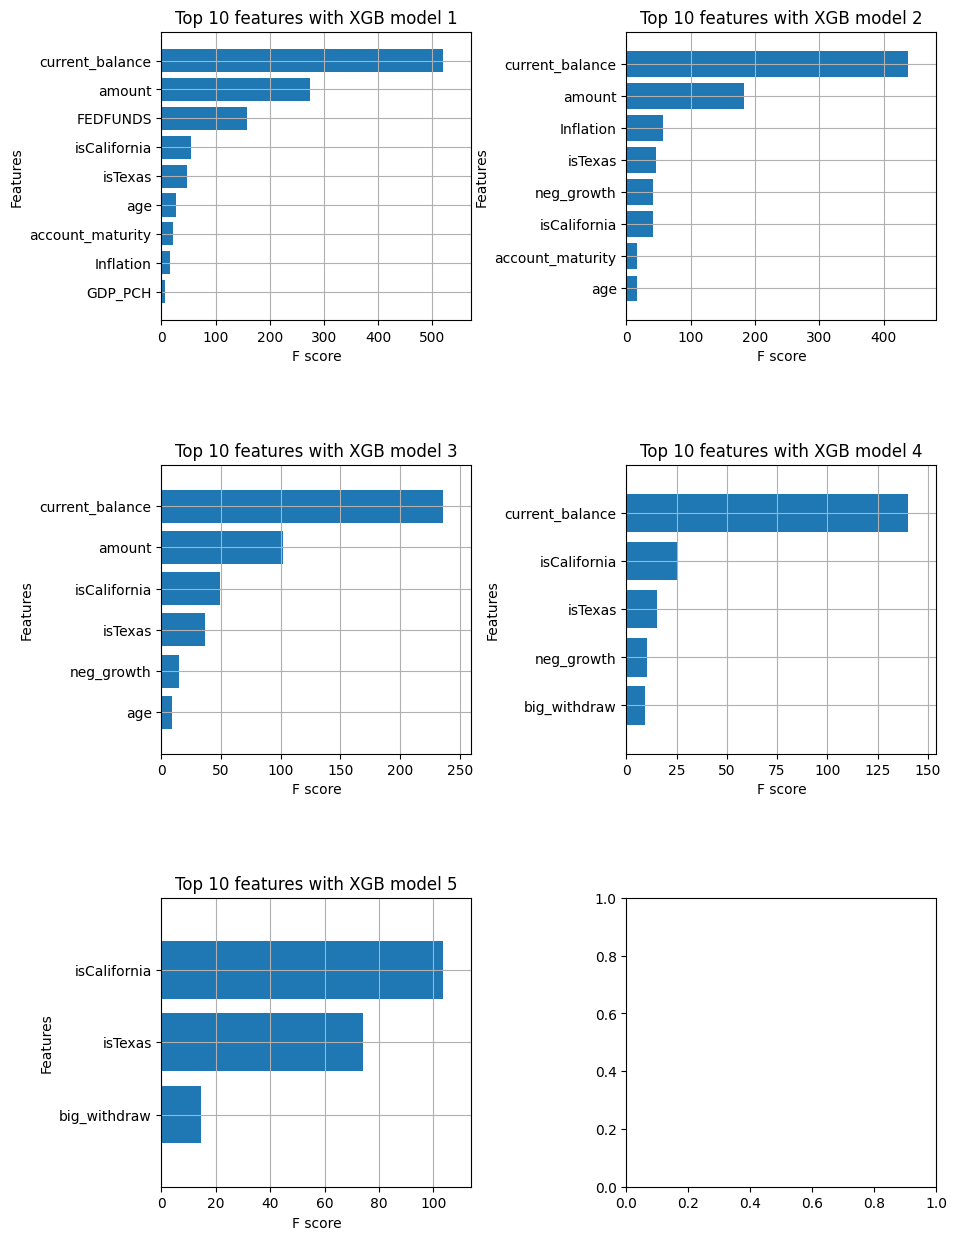

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 6 important features:
['current_balance', 'amount', 'FEDFUNDS', 'isCalifornia', 'Inflation', 'isTexas']
Total Time taken for featurewiz selection = 50 seconds
Output contains a list of 6 important features and a train dataframe
    Time taken to create entire pipeline = 57 second(s)


RandomizedSearchCV(cv=3, error_score=1,
                   estimator=Pipeline(steps=[('fw', FeatureWiz()),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True],
                                        'classifier__max_depth': [None],
                                        'classifier__max_features': ['log2',
                                                                     'sqrt'],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100]},
                   random_state=99, scoring='accuracy')

In [37]:
search.fit(X_train, y_train)

In [39]:
y_pred = search.predict(X_test)
y_pred.shape

(212635,)

In [22]:
y_train.value_counts()

False    1826012
True       87701
Name: will_churn, dtype: int64

0.5130907223357224
0.29074446680080485
0.02965623396613648
0.053822516062948134
0.5130907223357223


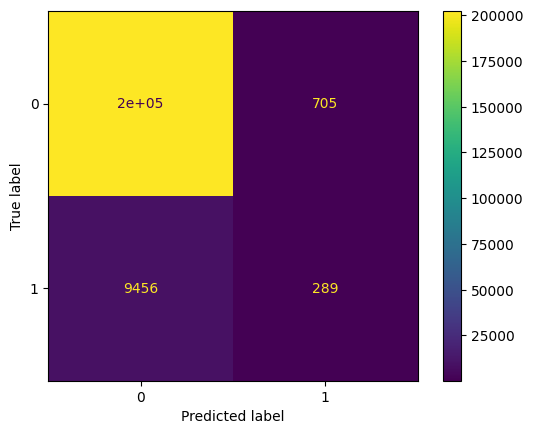

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score

print(balanced_accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [14]:
from sklearn.metrics import balanced_accuracy_score, mean_squared_error, accuracy_score
if modeltype == 'Regression':
    print(np.sqrt(mean_squared_error(y_test, y_pred)))
else:
    print(balanced_accuracy_score(y_test, y_pred))
    #print(accuracy_score(y_test, y_pred))


0.5


In [19]:
from sklearn import set_config
#### You can display your pipeline in a nice diagram if it is a Jupyter Notebook ##
set_config(display="diagram")
pipe

Pipeline(steps=[('fw', FeatureWiz()), ('classifier', RandomForestClassifier())])

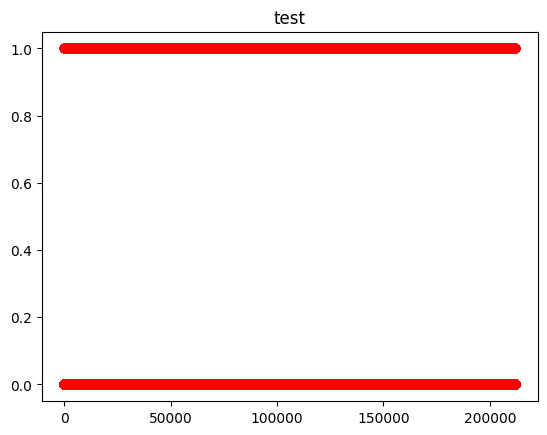

In [20]:
import matplotlib.pyplot as plt
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.title(regressorName)
    plt.show()
    return
plotGraph(y_test, y_pred, "test")

In [15]:
search.best_params_

{'classifier__min_samples_split': 10,
 'classifier__min_samples_leaf': 1,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 6,
 'classifier__bootstrap': True}

In [23]:
search.best_estimator_


Pipeline(steps=[('fw', FeatureWiz()),
                ('classifier',
                 RandomForestClassifier(max_features='auto',
                                        min_samples_leaf=4))])

In [16]:
df.corrwith(df["will_churn"])

customer_id        -0.029711
amount             -0.060970
start_balance      -0.003214
age                 0.008736
account_maturity   -0.010879
current_balance    -0.051241
FEDFUNDS           -0.036954
GDP_PCH             0.024053
Inflation          -0.042511
previous_balance   -0.041146
big_withdraw        0.017466
neg_growth         -0.018275
will_churn          1.000000
isCalifornia        0.027184
isTexas            -0.022818
dtype: float64